# Installing and Reading in of packages

In [3]:
# %pip install -r requirements.txt

In [ ]:
# %pip uninstall torch torchvision torchaudio
# %pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu126

In [6]:
import pandas as pd
import numpy as np
from transformers import pipeline
from sklearn.model_selection import train_test_split
import torch

from model_evaluation import get_model_evaluation
from model_extraction import get_model, get_tokenizer, get_pipeline
from model_training import train_model, train_lora_model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

# Reading in of Data

In [8]:
data = pd.read_csv("data/dataset.csv", header = None, names = ["Label", "Text"])
data = data[['Text', 'Label']]

print(data.head()) # First column: 1 - positive, 0 - negative
print(data.shape)

                                                Text  Label
0  the rock is destined to be the 21st century's ...      1
1  the gorgeously elaborate continuation of " the...      1
2                     effective but too-tepid biopic      1
3  if you sometimes like to go to the movies to h...      1
4  emerges as something rare , an issue movie tha...      1
(10662, 2)


In [9]:
testing_data = pd.read_csv('data/testing_data.csv')

print(testing_data)

                                                   Text  Label
0     this bracingly truthful antidote to hollywood ...      1
1     once the downward spiral comes to pass , auto ...      1
2     bray is completely at sea ; with nothing but a...      0
3     while the production details are lavish , film...      0
4     anyone who suffers through this film deserves ...      0
...                                                 ...    ...
1595  a dream cast of solid female talent who build ...      1
1596  it's an unusual , thoughtful bio-drama with a ...      1
1597  a gorgeous , somnolent show that is splendidly...      0
1598  it's tough to be startled when you're almost d...      0
1599  george lucas returns as a visionary with a tal...      1

[1600 rows x 2 columns]


# Model (Pre-built on Hugging Face)
For a start, we will try a pre-built model on Hugging Face that will analyse the text and give us a rating on whether it is `POSITIVE` or `NEGATIVE`.

In [10]:
sentiment_pipeline = pipeline("sentiment-analysis", model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english", device = 0) # device = 0
output = sentiment_pipeline(list(testing_data["Text"]))

Device set to use cuda:0


In [11]:
model_predictions = pd.Series(map(lambda x: x['label'], output))

label_mapping = {"POSITIVE": 1, "NEGATIVE": 0}
model_predictions = model_predictions.map(label_mapping)

## Model Evaluation
We will evaluate the model and look at the accuracy of the model.

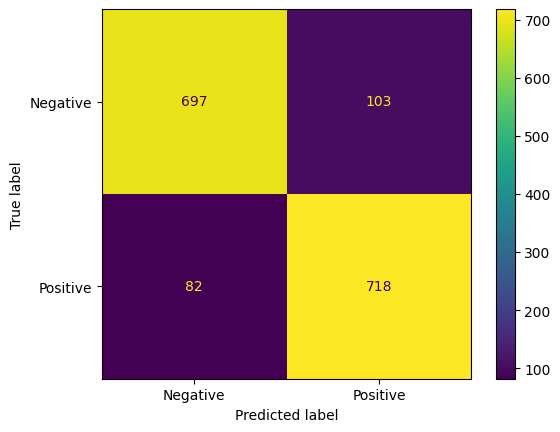

              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88       800
    Positive       0.87      0.90      0.89       800

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.88      0.88      0.88      1600

Accuracy: 0.884375
Recall: 0.8975
Precision: 0.8745432399512789
F1-score: 0.8858729179518815


In [12]:
labels = ['Negative', 'Positive']

get_model_evaluation(y_true=testing_data['Label'], y_pred=model_predictions, labels=labels)

# Custom Model
While we see that the pre-built model performs rather well (with an accuracy of around 88%), we will try to train a model on our own and fine-tune it based on the dataset provided. This would hopefully increase the accuracy of the model in determining the sentiment of the input text.

In [13]:
training_data = pd.read_csv('data/training_data.csv')
validation_data = pd.read_csv('data/validation_data.csv')
training_model_dir = "google-bert/bert-large-uncased"
# training_model_dir = "google-bert/bert-base-uncased"
# training_model_dir = "distilbert/distilbert-base-uncased"
num_epochs = 20
num_labels = 2 # Only 2 labels - Positive or Negative
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [ ]:
# train_model(training_data=training_data, 
#             validation_data=validation_data, 
#             model_dir=training_model_dir,
#             num_epochs=num_epochs,
#             num_labels=num_labels,
#             id2label=id2label,
#             label2id=label2id
#             )

In [14]:
train_lora_model(training_data=training_data, 
            validation_data=validation_data, 
            model_dir=training_model_dir,
            num_epochs=num_epochs,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id
            )

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Projects\Sentence Sentimental Analysis\model_training.py:122: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\Owent\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=Tru

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.353100,0.366686,0.865042,0.864683,0.868843,0.864995
2,0.340800,0.345318,0.890347,0.890316,0.890752,0.890332
3,0.298600,0.368656,0.889410,0.889358,0.890084,0.889390
4,0.261600,0.435385,0.885661,0.885653,0.885791,0.885669
5,0.231100,0.480441,0.878163,0.878154,0.878252,0.878156
6,0.180000,0.553746,0.881912,0.881847,0.882809,0.881935
7,0.179500,0.521639,0.883786,0.883646,0.885725,0.883820
8,0.144400,0.579285,0.883786,0.883749,0.884232,0.883770
9,0.121200,0.632491,0.880975,0.880971,0.881037,0.880981
10,0.120500,0.643304,0.880975,0.880971,0.881037,0.880981


c:\Users\Owent\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Owent\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args

{'eval_loss': 0.34531837701797485, 'eval_accuracy': 0.8903467666354264, 'eval_f1': 0.8903155517873067, 'eval_precision': 0.8907518395025253, 'eval_recall': 0.8903317382352735, 'eval_runtime': 5.5819, 'eval_samples_per_second': 191.154, 'eval_steps_per_second': 24.006, 'epoch': 20.0}
Best model saved at: models/bert-large-uncased_finetunedlora_20epochs_best


In [23]:
model_dir = 'google-bert/bert-large-uncased'
model_name = model_dir.split('/')[1]
num_epochs = 20
num_labels = 2
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = get_model(model_dir=model_dir, model_name=model_name, num_epochs=num_epochs, num_labels=num_labels, id2label=id2label, label2id=label2id, lora=True)
tokenizer = get_tokenizer(model_name)
pipeline = get_pipeline(model=model, tokenizer=tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


In [24]:
model_predictions = pd.Series(map(lambda x: x['label'], pipeline(list(testing_data['Text']))))

label_mapping = {"POSITIVE": 1, "NEGATIVE": 0}
model_predictions = model_predictions.map(label_mapping)

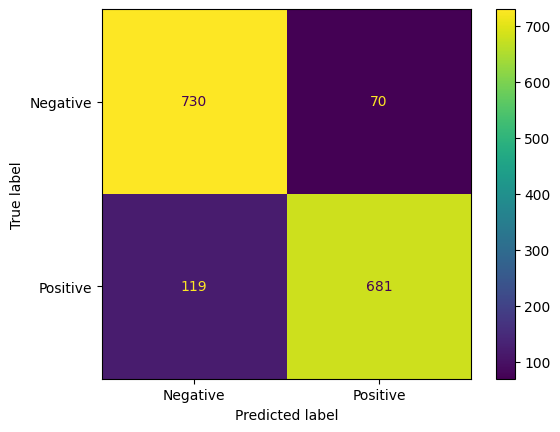

              precision    recall  f1-score   support

    Negative       0.86      0.91      0.89       800
    Positive       0.91      0.85      0.88       800

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.88      0.88      0.88      1600

Accuracy: 0.881875
Recall: 0.85125
Precision: 0.9067909454061251
F1-score: 0.8781431334622823


In [25]:
labels = ['Negative', 'Positive']

get_model_evaluation(y_true=testing_data['Label'], y_pred=model_predictions, labels=labels)